# TensorFlow Tutorial #08
# Transfer Learning

by [Magnus Erik Hvass Pedersen](http://www.hvass-labs.org/)
/ [GitHub](https://github.com/Hvass-Labs/TensorFlow-Tutorials) / [Videos on YouTube](https://www.youtube.com/playlist?list=PL9Hr9sNUjfsmEu1ZniY0XpHSzl5uihcXZ)

## Introduction

우리는 이전 튜토리얼 7에서 이미지를 분류하기 위해 미리 학습된 인셉션 모델을 사용하는 방법을 보였다. 불행하게도 인셉션 모델은 사람을 구분할 수 없어보인다. 이유는 인셉션 모델 학습 동안 사용된 클래스에 대해 몇몇 혼란스러운 텍스트 라벨을 가진 데이터셋이다.

인셉션 모델은 사실 꽤 이미지로부터 유용한 정보를 추출할 수 있다. 그래서 우리는 다른 데이터셋을 사용해 인셉션 모델을 대신 학습할 수 있다. 하지만 새로운 데이터셋에 인셉션 모델을 완전히 학습하는 것은 매우 강력하고 비싼 컴퓨터를 사용해 몇주가 걸린다

우리는 대신 이미 학습된 인셉션 모델을 재사용 할 수 있고 단지 마지막 분류를 수행하는 레이어만 바꿔줄 수 있다. 이것을 전이 학습(Transfer Learning) 이라 부른다.

이 튜토리얼은 이전 튜토리얼롤부터 만들어졌으므로 텐서플로에서 신경망을 학습하고 만드는 방법에 대한 이전 튜토리얼이나 튜토리얼 7에 익숙해야만 한다. 이 튜토리얼에 소스 코드의 어떤 부분은 `inception.py` 파일에 있다 

## Flowchart

아래의 차트는 전이학습을 위해 인셉션 모델을 사용할 때 자료가 어떻게 흘러가는지 보여준다. 첫째 우리는 이미지를 입력하고, 인셉션 모델을 가지고 이미지를 처리한다. 인셉션 모델의 최종 분류 레이어 전에, 전이 값 이라고 불리는 것을 캐쉬 파일에 저장한다

캐쉬 파일을 사용하는 이유는 인셉션 모델을 가지고 이미지를 처리하는데 오랜 시간이 걸리기 때문이다. 쿼드코어 2GHz CPU 를 가진 내 노트북 컴퓨터는 인셉션 모델을 사용해 초당 3장의 이미지를 처리할 수 있다. 만약 각 이미지가 한번 이상 처리된다면, 우리는 전이 값을 캐쉬함으로써 시간을 줄일 수 있다.

전이값을 때때로 병목 값(bottlenect-values)라 불리기도 하지만 혼란스러운 용어이므로 여기서는 사용하지 않는다.

새로운 데이터의 모든 이미지를 인셉션 모델을 통해 처리하고 결과 전이값을 캐쉬 파일에 저장되면, 해당 전이 값을 다른 신경망에 대한 입력으로 사용할 수 있다. 새로운 데이터의 클래스를 이용해 두번째 신경망을 학습할 것이므로 이 신겸앙은 인셉션으로부터의 전이값에 기반하여 이미지를 분류하는 방법을 배운다.

이런 방식에서, 인셉션 모델은 이미지로부터의 유용한 정보를 추출하는데 사용되고 다른 신경망은 실제 분류를 위해 사용된다

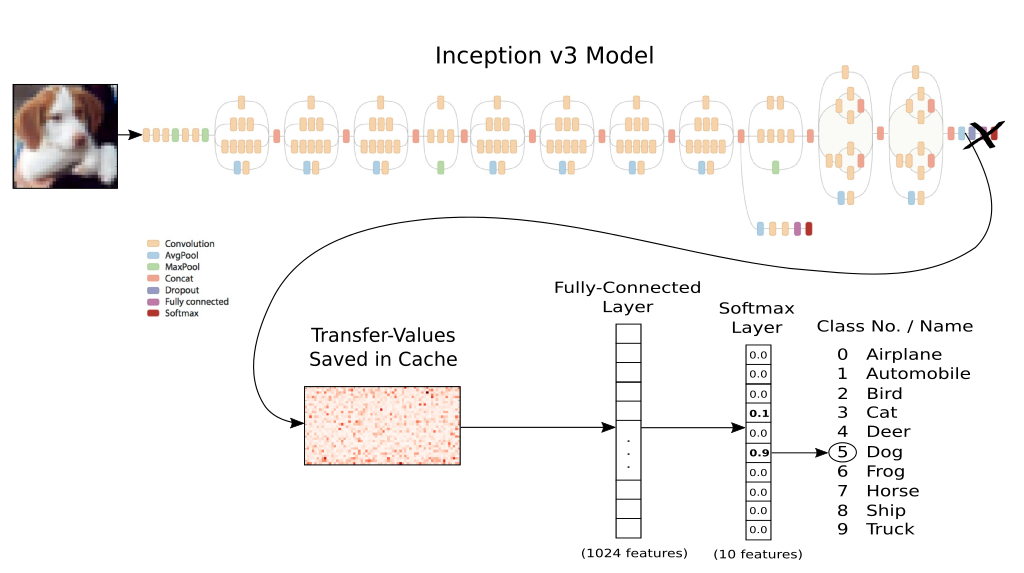

In [1]:
from IPython.display import Image, display
Image('images/08_transfer_learning_flowchart.png')

## Imports

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import time
from datetime import timedelta
import os

# Functions and classes for loading and using the Inception model.
import inception

# We use Pretty Tensor to define the new classifier.
import prettytensor as pt

파이썬 3.5.2 (아나콘다)와 텐서플로 1.0.1 버젼으로 함

In [3]:
tf.__version__

'1.0.1'

PrettyTensor version:

In [4]:
pt.__version__

'0.7.4'

## Load Data for CIFAR-10 

In [5]:
import cifar10

데이터 차원은 이미 cifar10 모듈안에 정의되어 있으므로 이것을 불러와 사용할 필요가 있다

In [6]:
from cifar10 import num_classes

데이터셋이 컴퓨터에 저장된 경로를 설정하라

In [7]:
# cifar10.data_path = "data/CIFAR-10/"

CIFAR-10 데이터셋은 약 163 MB이고 주어진 경로에 CIFAR-10 데이터셋이 없으면 자동으로 다운로드될 것이다.

In [8]:
cifar10.maybe_download_and_extract()

Data has apparently already been downloaded and unpacked.


클래스이름을 불러온다.

In [9]:
class_names = cifar10.load_class_names()
class_names

Loading data: data/CIFAR-10/cifar-10-batches-py/batches.meta


['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

학습데이터셋을 불러온다. 이것은 이미지, 정수로된 클래스 숫자, 라벨이라 불리는 One-Hot 인코딩된 클래스 숫자 배열을 반환한다

In [10]:
images_train, cls_train, labels_train = cifar10.load_training_data()

Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_1
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_2
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_3
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_4
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_5


테스트셋을 불러온다

In [11]:
images_test, cls_test, labels_test = cifar10.load_test_data()

Loading data: data/CIFAR-10/cifar-10-batches-py/test_batch


CIFAR-10 데이터셋은 불러와지고, 60,000 장의 이미지들과 관련된 라벨로 구성된다. 이 데이터셋은 학습데이터셋과 테스트셋의 2개의 상호 배반적인 하위 데이터셋으로 나뉘어진다.

In [12]:
print("Size of:")
print("- Training-set:\t\t{}".format(len(images_train)))
print("- Test-set:\t\t{}".format(len(images_test)))

Size of:
- Training-set:		50000
- Test-set:		10000


### Helper-function for plotting images

3x3 격자에 9개의 이미지를 출력하고, 각 이미지에 대해 예측 클래스와 실제값을 보여주는 함수

In [13]:
def plot_images(images, cls_true, cls_pred=None, smooth=True):
    
    # 이미지의 길이와 cls_true의 값이 9가 맞는지 확인 아니면 에러
    assert len(images) == len(cls_true) == 9

    # subplots로 3x3 격자 figure를 만듬
    fig, axes = plt.subplots(3, 3)

    # 앙상블과 최고 신경망을 출력하는 것이 필요하다면 수직 간격을 조정해라
    if cls_pred is None:
        hspace = 0.3
    else:
        hspace = 0.6
    # 각 격자의 떨어진 정도를 조정함
    fig.subplots_adjust(hspace=hspace, wspace=0.3)
    
    # 각 격자의 순서대로 넣기 위해 enumerate를 사용
    for i, ax in enumerate(axes.flat):
        # 보간법 타입
        if smooth:
            interpolation = 'spline16'
        else:
            interpolation = 'nearest'

        # 이미지 표시
        ax.imshow(images[i, :, :, :],
                  interpolation=interpolation)
            
        # 실제 클래스의 이름
        cls_true_name = class_names[cls_true[i]]

        # 실제와 예측 클래스를 보여준다
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true_name)
        else:
            # 예측된 클래스의 이름
            cls_pred_name = class_names[cls_pred[i]]

            xlabel = "True: {0}\nPred: {1}".format(cls_true_name, cls_pred_name)

        # x 축 라벨에 실제 클래스를 보여줌
        ax.set_xlabel(xlabel)
        
        # 눈금 지움
        ax.set_xticks([])
        ax.set_yticks([])
    
    plt.show()

### Plot a few images to see if data is correct

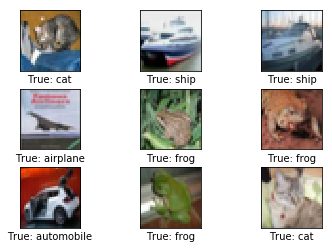

In [14]:
# 테스트셋에서 첫 9개 이미지 가져옴
images = images_test[0:9]

# 이들 이미지의 실제 클래스값 얻음
cls_true = cls_test[0:9]

# 위의 함수를 이용해 나타냄
plot_images(images=images, cls_true=cls_true, smooth=False)

## Download the Inception Model

인터넷으로부터 인셉션 모델을 다운받는다. 데이터파일을 저장하려는 기본 디렉토리. 이 디렉토리는 존재하지 않으면 만들어진다.

In [15]:
# inception.data_dir = 'inception/'

디렉토리에 존재하지 않으면 인셉션 모델에 대한 자료를 받는다. 이것은 85 MB.

See Tutorial #07 for more details.

In [16]:
inception.maybe_download()

Data has apparently already been downloaded and unpacked.


## Load the Inception Model

인셉션 모델을 불러왔으므로 이미지를 분류하기 위한 준비가 되었다.

deprecation 경고는 이 프로그램이 미래에 실패할 수도 있다는 것을 나타낸다

In [17]:
model = inception.Inception()

## Calculate Transfer-Values

인셉션 모델의 전이값을 캐쉬하기 위한 도움 함수를 불러온다

In [18]:
from inception import transfer_values_cache

학습데이터셋과 테스트 데이터셋의 캐쉬를 위한 파일 경로들을 설정

In [19]:
file_path_cache_train = os.path.join(cifar10.data_path, 'inception_cifar10_train.pkl')
file_path_cache_test = os.path.join(cifar10.data_path, 'inception_cifar10_test.pkl')

In [20]:
print("Processing Inception transfer-values for training-images ...")

# 이미지를 스케일링 한다 왜냐하면 인셉션은 0과 255 사이의 픽셀들을 필요하기 때문이다
# 반대로 CIFAR-10 함수는 0.0 과 1.0 사이의 픽셀들을 반환한다
images_scaled = images_train * 255.0

# 만약 전이값이 이미 계산되어 있다면 그것을 불러오고 그렇지 않다면,
# 계산하고 캐쉬파일에 저장한다
transfer_values_train = transfer_values_cache(cache_path=file_path_cache_train,
                                              images=images_scaled,
                                              model=model)

Processing Inception transfer-values for training-images ...
- Data loaded from cache-file: data/CIFAR-10/inception_cifar10_train.pkl


In [21]:
print("Processing Inception transfer-values for test-images ...")

# 이미지를 스케일링 한다 왜냐하면 인셉션은 0과 255 사이의 픽셀들을 필요하기 때문이다
# 반대로 CIFAR-10 함수는 0.0 과 1.0 사이의 픽셀들을 반환한다
images_scaled = images_test * 255.0

# 만약 전이값이 이미 계산되어 있다면 그것을 불러오고 그렇지 않다면,
# 계산하고 캐쉬파일에 저장한다
transfer_values_test = transfer_values_cache(cache_path=file_path_cache_test,
                                             images=images_scaled,
                                             model=model)

Processing Inception transfer-values for test-images ...
- Data loaded from cache-file: data/CIFAR-10/inception_cifar10_test.pkl


전이값을 가진 배열의 모양을 확인. 학습 데이터셋에는 50,000 장의 이미지가 있고 각각 2048개의 전이 값을 가진다.

In [22]:
transfer_values_train.shape

(50000, 2048)

비슷하게, 테스트셋에는 10,000 장의 이미지가 있고 각각 2048개의 전이 값을 가진다.

In [23]:
transfer_values_test.shape

(10000, 2048)

### Helper-function for plotting transfer-values

In [24]:
def plot_transfer_values(i):
    print("Input image:")
    
    # ㅔㅌ스트셋으로부터 i 번째 이미지를 글니다
    plt.imshow(images_test[i], interpolation='nearest')
    plt.show()

    print("Transfer-values for the image using Inception model:")
    
    # 전이 값을 이미지로 바꾼다
    img = transfer_values_test[i]
    img = img.reshape((32, 64))

    # 전이값을 이미지로 그린다
    plt.imshow(img, interpolation='nearest', cmap='Reds')
    plt.show()

Input image:


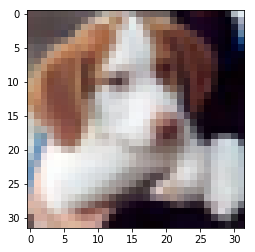

Transfer-values for the image using Inception model:


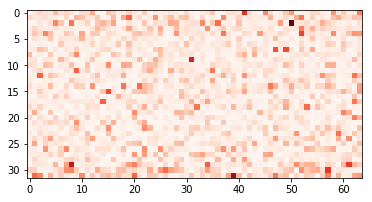

In [25]:
plot_transfer_values(i=16)

Input image:


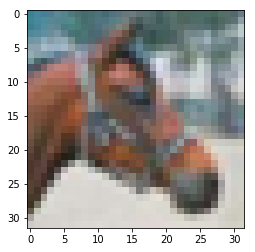

Transfer-values for the image using Inception model:


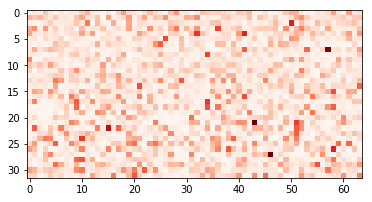

In [26]:
plot_transfer_values(i=17)

## Analysis of Transfer-Values using PCA

scikit-learn의 주성분분석(PCA, Principal Component Analysis)를 이용해 전이값 배열의 길이를 2048에서 2로 줄이면 그릴 수 있게 된다

In [27]:
from sklearn.decomposition import PCA

새 PCA 객체와 목표 배열 길이를 2로 설정한다

In [28]:
pca = PCA(n_components=2)

PCA를 계산하는데 시간이 많이 걸리므로 3000개만을 샘플로 한다. 원한다면 완전한 데이터셋을 사용해서 시도할 수 있다

In [29]:
transfer_values = transfer_values_train[0:3000]

선택된 샘플들에 대한 클래스 숫자를 얻는다

In [30]:
cls = cls_train[0:3000]

각 샘플에 대한 2048 개의 전이값과 3000개의 샘플을 가진 배열인지 확인

In [31]:
transfer_values.shape

(3000, 2048)

PCA를 사용해 전이값 배열을 2048에서 2개의 요소로 줄인다

In [32]:
transfer_values_reduced = pca.fit_transform(transfer_values)

각 샘플에 대해 2개의 값과 3000개의 샘플을 가진 배열인지 확인

In [33]:
transfer_values_reduced.shape

(3000, 2)

줄어딘 전이값을 그리기 위한 도움 함수

In [34]:
def plot_scatter(values, cls):
    # 각 클래스에 대해 다른 색깔을 갖는 컬러맵을 만든다
    import matplotlib.cm as cm
    cmap = cm.rainbow(np.linspace(0.0, 1.0, num_classes))

    # 각 샘플에 대한 색깔을 얻는다
    colors = cmap[cls]

    # x와 y 값을 추출
    x = values[:, 0]
    y = values[:, 1]

    # 그린다
    plt.scatter(x, y, color=colors)
    plt.show()

PCA를 사용해 줄어든 전이값을 그린다. CIFAR-10 데이터셋 안에 다른 클래스에 대해 10개의 다른 색깔이 있다. 이 색깔들은 함께 그룹지어지지만 매우 넓게 겹쳐있다. 왜냐하면 PCA가 전이값을 적절히 분리할 수 없기 때문이다.

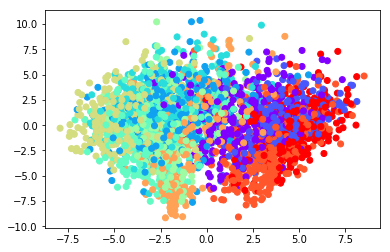

In [35]:
plot_scatter(transfer_values_reduced, cls)

## Analysis of Transfer-Values using t-SNE

In [36]:
from sklearn.manifold import TSNE

차원 감소를 위한 또다른 방법은 t-SNE다. 불행하게도, t-SNE는 매우 느리기 때문에 우리는 먼저 PCA를 사용해 전이값을 2048에서 50으로 줄인다

In [37]:
pca = PCA(n_components=50)
transfer_values_50d = pca.fit_transform(transfer_values)

최조 차원 감소를 위해 새로운 t-SNE 객체를 만들고 목표를 2차원으로 설정

In [38]:
tsne = TSNE(n_components=2)

t-SNE를 사용해 마지막 차원감소를 수행. scikit-learn 안에 t-SNE의 현재 구현은 매우 많은 데이터를 다룰 수 없으므로 만약 완전한 데이터셋을 사용한다면 멈출 것이다.

In [39]:
transfer_values_reduced = tsne.fit_transform(transfer_values_50d) 

각 샘플에 대해 2개의 값과 3000개의 샘플을 가진 배열인지 확인

In [40]:
transfer_values_reduced.shape

(3000, 2)

t-SNE를 사용해 2차원으로 줄어든 전이값을 그리면 위의 PCA 그림보다 더 잘 나눠지는 것을 볼 수 있다.

인셉션 모델으로부터의 전이값이 여전히 겹친 부분이 있어서 완벽하게 분리하지는 못하지만 CIFAR-10 이미지를 클래스 속에 분리하기 위한 충분한 정보를 포함하고 있다는 것을 의미한다

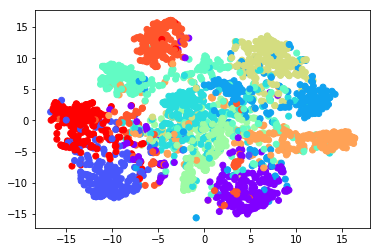

In [41]:
plot_scatter(transfer_values_reduced, cls)

## New Classifier in TensorFlow

이제 우리는 텐서플로 안에 다른 신경망을 만들 것이다. 이 신경망은 인셉션 모델로부터의 전이값을 입력으로 가지고 CIFAR-10 이미지에 대해 예측 클래스를 출력할 것이다

이미 텐서플로에서 신경망을 만드는 방법에 익숙하다고 가정한다. 그렇지 않다면 튜토리얼 3을 보라

### Placeholder Variables

인셉션 모델 객체에서 변수로 저장되어있는 전이값에 대한 배열 길이가 필요하다

In [42]:
transfer_len = model.transfer_len

우리가 만드는 새로운 신경망 속에 인셉션 모델로부터의 전이값을 입력 받기 위한 placeholder 변수를 만든다. 이 변수의 모양은 `[None, transfer_len]` 이고 이는 변할 수 있는 샘플의 수와 샘플 당 `transfer_len`과 동일한 2048개의 요소를 갖는 입력 배열을 의미한다.

In [43]:
x = tf.placeholder(tf.float32, shape=[None, transfer_len], name='x')

각 이미지의 실제 클래스 라벨을 입력받기 위한 또다른 placeholder 변수를 만든다. 이는 데이터셋에서 각 가능한 클래스 중 하나인 10개의 요소를 갖는 One-Hot 인코딩되 배열이다

In [44]:
y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')

정수로된 실제 클래스를 계산한다. 이것 역시 placeholder 변수가 될 수 있다

In [45]:
y_true_cls = tf.argmax(y_true, dimension=1)

### Neural Network

CIFAR-10 데이터셋에 대해 분류를 하는 신경망을 만든다. 이것은 placeholder 변수 `x`에 보낼 인셉션 모델로부터의 전이값을 입력으로 갖는다. 이 신경망은 `y_pred` 안에 예측 클래스를 출력한다

신경망을 구성하기 위해 Pretty Tensor를 사용하는 방법에 대해 더 자세한 것은 튜토리얼 3을 보라

In [46]:
# Pretty Tensor 객체로 전이값을 Wrap 한다
x_pretty = pt.wrap(x)

with pt.defaults_scope(activation_fn=tf.nn.relu):
    y_pred, loss = x_pretty.\
        fully_connected(size=1024, name='layer_fc1').\
        softmax_classifier(num_classes=num_classes, labels=y_true)

### Optimization Method

최적화 반복 수행의 수를 추적하기 위한 변수를 만든다

In [47]:
global_step = tf.Variable(initial_value=0,
                          name='global_step', trainable=False)

새로운 신경망을 최적화하기 위한 방법

In [48]:
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(loss, global_step)

### Classification Accuracy

정수인 예측 클래스 숫자를 계산한다. `y_pred`는 10 요소를 갖는 배열이다. 클래스 숫자는 이 배열에서 가장 큰 요소의 인덱스이다.

In [49]:
y_pred_cls = tf.argmax(y_pred, dimension=1)

각 이미지의 실제 클래스와 예측 클래스가 동일한지를 나타내는 진리값 벡터를 만든다

In [50]:
correct_prediction = tf.equal(y_pred_cls, y_true_cls)

correct_prediction 이 boolean 값이기 때문에 float32 형태로 가져와 정확도를 계산한다.

In [51]:
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

## TensorFlow Run

### Create TensorFlow Session

텐서플로 그래프가 만들어지면, 우리는 그래프를 실행하기 위해 사용되는 텐서플로 세션을 만들어야만 한다.

In [52]:
session = tf.Session()

### Initialize Variables

최적화를 시작하기전에 새로운 신경망의 모든 변수들을 초기화해야만 한다

In [53]:
session.run(tf.global_variables_initializer())

### Helper-function to get a random training-batch

학습 데이터셋에 5만 개 이미지가 있다. 모든 이미지를 사용해 그라디언트를 계산하는데에는 너무 오래걸린다. 그래서 매 반복마다 이미지의 표본을 사용하는 확률적 기울기 강하(Stochastic Gradient Descent)를 사용한다.

만약 컴퓨터가 RAM 때문에 너무 느리거나 멈추면, 더 작은 수를 시도해라.

In [54]:
train_batch_size = 64

학습 데이터셋으로부터 전이값의 무작위 배치를 선택하는 함수

In [55]:
def random_batch():
    # 학습 데이터셋에서 이미지의 수(전이값)
    num_images = len(transfer_values_train)

    # 무작위 인덱스 만들기
    idx = np.random.choice(num_images,
                           size=train_batch_size,
                           replace=False)

    # 무작위 인덱스를 이용해 이미지와 라벨을 선택함.
    # 우리는 이미지 대신에 전이값을 사용
    x_batch = transfer_values_train[idx]
    y_batch = labels_train[idx]

    return x_batch, y_batch

### Helper-function to perform optimization

최적화 반복을 수행함으로써 신경망 레이어의 변수들을 점진적으로 향상 시킨다. 각 반복에서 새로운 데이터 배치가 선택되고 이들 표본을 사용해 최적화기를 실행한다. 진행은 매 100번 반복마다 출력된다.

In [56]:
def optimize(num_iterations):
    # 아래에 사용된 시간을 나타내는 start_time
    start_time = time.time()

    for i in range(num_iterations):
        # 학습 데이터의 표본을 얻는다.
        # x_batch는 이미지의 표본(전이값)을 가지고 있고,
        # y_true_batch는 이들 이미지에 대한 실제 라벨을 갖고 있다.
        x_batch, y_true_batch = random_batch()

        # 텐서플로 그래프에서 placeholder 변수의 이름을 갖는 사전속에 표본을 넣는다.
        feed_dict_train = {x: x_batch,
                           y_true: y_true_batch}

        # 학습 자료의 이 표본을 사용해 최적화기를 실행한다.
        # 텐서플로는 feed_dict_train에 있는 변수들을 placeholder 변수에 할당하고 실행한다.
        # global_step 값을 가져온다
        i_global, _ = session.run([global_step, optimizer],
                                  feed_dict=feed_dict_train)

        # 매 100번 반복마다와 마지막에 상태 표시
        if (i_global % 100 == 0) or (i == num_iterations - 1):
            # 학습 배치에 대한 정확도 계산
            batch_acc = session.run(accuracy,
                                    feed_dict=feed_dict_train)

            # 상태 출력
            msg = "Global Step: {0:>6}, Training Batch Accuracy: {1:>6.1%}"
            print(msg.format(i_global, batch_acc))

    # 끝난 시간
    end_time = time.time()

    # 시작과 끝 시간 차이
    time_dif = end_time - start_time

    # 시간 사용 출력
    print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))

## Helper-Functions for Showing Results

### Helper-function to plot example errors

잘못 분류된 테스트셋의 이미지를 표시하는 함수

In [57]:
def plot_example_errors(cls_pred, correct):
    # 이 함수는 print_test_accuracy() 로부터 불러와진다.
    # cls_pred는 테스트 셋에 모든 이미지에 대한 예측된 클래스의 배열
    
    # correct 는 테스트 셋에 모든 이미지에 대한 실제와 예측의 진리값
    
    # 잘못 분류된 인덱스를 얻는다
    incorrect = (correct == False)
    
    # 올바르게 분류되지 않은 이미지를 얻는다
    images = images_test[incorrect]
    
    # 이들 이미지의 예측 클래스를 얻는다
    cls_pred = cls_pred[incorrect]

    # 이들 이미지의 실제 클래스를 얻는다.
    cls_true = cls_test[incorrect]
    
    # 9개의 이미지를 나타낸다.
    plot_images(images=images[0:9],
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])

### Helper-function to plot confusion matrix

In [58]:
# 혼동행렬을 계산하기 위해 sklearn 으로부터 함수를 불러온다
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cls_pred):
    # 이건 아래의 print_test_accuracy()에서 호출된다

    # cls_pred는 테스트셋에 모든 이미지에 대한 예측 클래스 숫자의 배열

    # sklearn 을 사용해 혼동 행렬을 얻는다
    cm = confusion_matrix(y_true=cls_test,  # True class for test-set.
                          y_pred=cls_pred)  # Predicted class.

    # 혼동 행렬을 텍스트로 출력한다
    for i in range(num_classes):
        # 각 라인에 클래스 이름을 더한다
        class_name = "({}) {}".format(i, class_names[i])
        print(cm[i, :], class_name)

    class_numbers = [" ({0})".format(i) for i in range(num_classes)]
    print("".join(class_numbers))

### Helper-functions for calculating classifications

이 함수는 이미지의 예측 클래스를 계산하고, 각 이미지의 분류가 올바른지 나타내는 진리값을 반환한다

이 계산은 배치에서 수행된다 왜냐하면 RAM을 많이 사용할 수 있기 때문이다. 만약 컴퓨터가 멈춘다면 배치 사이즈를 줄이고 다시 해라

In [59]:
# 데이터를 몇개씩 나눌 것인지
batch_size = 256

def predict_cls(transfer_values, labels, cls_true):
    # 이미지의 수
    num_images = len(transfer_values)

    # 배치에서 계산되기 위한 예측 클래스의 배열을 할당하고 이 배열 속에 채운다.
    cls_pred = np.zeros(shape=num_images, dtype=np.int)

    # 배치에 대해 예측 클래스를 계산한다.
    # 모든 배치에 대해 반복할 것

    # 배치를 위한 순번 초기화
    i = 0
    
    # i가 테스트셋 숫자보다 작은 경우 계속
    while i < num_images:
        # j 는 배치의 끝 번호
        j = min(i + batch_size, num_images)

        # i부터 j까지의 이미지와 라벨을 feed_dict 으로 만든다
        feed_dict = {x: transfer_values[i:j],
                     y_true: labels[i:j]}

        # 텐서플로를 사용해 예상 클래스를 만든다
        cls_pred[i:j] = session.run(y_pred_cls, feed_dict=feed_dict)

        # 다음 배치를 위해 i를 j로 바꾼다
        i = j
        
    # 예상 클래스와 실제 클래스르 비교한다.
    correct = (cls_true == cls_pred)

    return correct, cls_pred

테스트 셋에 대한 예측 클래스를 계산한다

In [60]:
def predict_cls_test():
    return predict_cls(transfer_values = transfer_values_test,
                       labels = labels_test,
                       cls_true = cls_test)

### Helper-functions for calculating the classification accuracy

이 함수는 각 이미지가 정확히 분류되었는지 아닌지에 대한 진리값이 주어졌을 때 분류 정확도를 계산한다.
E.g. `cls_accuracy([True, True, False, False, False]) = 2/5 = 0.4`

In [61]:
def classification_accuracy(correct):
    return correct.mean(), correct.sum()

### Helper-function for showing the classification accuracy

테스트 셋에 대한 분류 정확도를 출력하는 함수

테스트 셋에 모든 이미지에 대한 분류를 계산한다. 결과는 이 함수로부터 직접적으로 위의 함수에 호출되어 재사용된다. 그래서 분류는 각 함수마다 재 계산되지 않는다.

In [62]:
def print_test_accuracy(show_example_errors=False,
                        show_confusion_matrix=False):

    # 테스트셋에 모든 이미지에 대해 맞았는지 틀렸는지 나타낸다.
    correct, cls_pred = predict_cls_test()
    
    # 정확도를 계산한다.
    acc, num_correct = classification_accuracy(correct)
    
    # 이미지의 수
    num_images = len(correct)

    # 정확도 출력
    msg = "테스트셋에 대한 정확도: {0:.1%} ({1} / {2})"
    print(msg.format(acc, num_correct, num_images))

    # 원한다면 틀린 그림을 표시할 수 있다
    if show_example_errors:
        print("Example errors:")
        plot_example_errors(cls_pred=cls_pred, correct=correct)

    # 원한다면 혼동 행렬을 표시할 수 있다
    if show_confusion_matrix:
        print("Confusion Matrix:")
        plot_confusion_matrix(cls_pred=cls_pred)

## Results

## Performance before any optimization

테스트 셋에 대한 정확도는 매우 낮다 왜냐하면 초기화만되고 최적화되지 않았기 때문이다 그래서 이미지는 무작위로 분류되었다.

In [63]:
print_test_accuracy(show_example_errors=False,
                    show_confusion_matrix=False)

테스트셋에 대한 정확도: 10.9% (1092 / 10000)


## Performance after 10,000 optimization iterations

10,000 번 최적화 반복 이후, 약 90% 이상의 정확도를 보인다. 테스트셋에 대해 80% 정확도를 보인 튜토리얼 6에서의 기본적인 콘볼루션 신경망과 비교하라

In [64]:
optimize(num_iterations=10000)

Global Step:    100, Training Batch Accuracy:  85.9%
Global Step:    200, Training Batch Accuracy:  90.6%
Global Step:    300, Training Batch Accuracy:  84.4%
Global Step:    400, Training Batch Accuracy:  85.9%
Global Step:    500, Training Batch Accuracy:  85.9%
Global Step:    600, Training Batch Accuracy:  82.8%
Global Step:    700, Training Batch Accuracy:  84.4%
Global Step:    800, Training Batch Accuracy:  89.1%
Global Step:    900, Training Batch Accuracy:  89.1%
Global Step:   1000, Training Batch Accuracy:  90.6%
Global Step:   1100, Training Batch Accuracy:  92.2%
Global Step:   1200, Training Batch Accuracy:  85.9%
Global Step:   1300, Training Batch Accuracy:  90.6%
Global Step:   1400, Training Batch Accuracy:  90.6%
Global Step:   1500, Training Batch Accuracy:  95.3%
Global Step:   1600, Training Batch Accuracy:  89.1%
Global Step:   1700, Training Batch Accuracy:  90.6%
Global Step:   1800, Training Batch Accuracy:  95.3%
Global Step:   1900, Training Batch Accuracy: 

테스트셋에 대한 정확도: 90.1% (9015 / 10000)
Example errors:


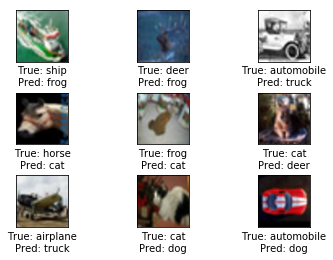

Confusion Matrix:
[894   7  20   3  10   1   1   2  40  22] (0) airplane
[  5 931   3   3   1   2   1   1   4  49] (1) automobile
[ 12   0 903  16  31   9  19   5   1   4] (2) bird
[  7   2  33 773  39  99  27  10   5   5] (3) cat
[  3   0  25  15 909   8  18  19   2   1] (4) deer
[  4   0  15  51  23 884   8  13   1   1] (5) dog
[  3   1  28  13  21   6 924   1   3   0] (6) frog
[  5   0  12  11  43  27   0 897   1   4] (7) horse
[ 28   4   1   2   2   1   2   0 947  13] (8) ship
[  4  25   2   0   1   2   1   1  11 953] (9) truck
 (0) (1) (2) (3) (4) (5) (6) (7) (8) (9)


In [65]:
print_test_accuracy(show_example_errors=True,
                    show_confusion_matrix=True)

## Close TensorFlow Session

텐서플로 사용을 마쳤고, 리소스를 풀기 위해 세션을 닫는다. 텐서플로 세션은 model 객체 안에 있고 그래서 객체를 통해 세션을 닫는다

In [66]:
# This has been commented out in case you want to modify and experiment
# with the Notebook without having to restart it.
# model.close()
# session.close()

## Conclusion

이전 튜토리얼 6에서 테스트셋에 약 80% 정확도를 갖는 CIFAR-10 데이터셋을 분류하기 위한 신경망을 학습하는데 노트북에서 15시간이 걸렸다.

이 튜토리얼에서 우리는 CIFAR-10 데이터셋에 대해 약 90% 분류 정확도를 성취할 수 있는 튜토리얼 7로부터의 인셉션 모델을 사용했다. 인셉션 모델을 통해 CIFAR-10 데이터셋에 모든 이미지를 보내고, 전이값이라 불리는 최종 분류 레이어 이전의 값을 가져온다. 이들 전이값을 입력으로 갖는 또다른 신경망을 만들고 CIFAR-10 클래스의 출력을 냈다.

CIFAR-10 데이터셋은 총 60,000 장의 이미지가 있다. GPU 없는 노트북을 사용해 모든 이미지에 대해 인셉션 모델의 전이값을 계산하는 데에는 약 6시간이 걸린다. 그리고 이들 전이값의 젤 위에 새로운 분류기를 학습하는 것은 몇분이면 된다. 그러므로 전이학습의 결합된 사용시간은 CIFAR-10 데이터셋에 대해 직접적으로 학습시키는 시간의 절반보다도 적고, 유의미하게 더 높은 분류 정확도를 성취했다.

인셉션 모델로 하는 전이학습은 자신의 데이터셋에 대해 이미지 분류기를 만드는데에 유용하다

## Exercises

* PCA와 t-SNE 그림에 전체 데이터셋을 사용해보라. 무슨 일이 일어나는가?
* 새로운 분류하는 신경망을 바꿔보라. 만약 완전 연결 레이어를 제거하거나 더 많은 완전 연결 레이어를 추가하면 무슨 일이 일어나는가?
* 최적화 반복을 덜하거나 더 하면 무슨 일이 일어나는가?
* 최적화를 위한 `learning_rate`를 바꾼다면 무슨 일이 일어나는가?
* 튜토리얼 6에서 했던 것처럼 CIFAR-10 이미지에 대해 무작위 왜곡을 어떻게 구현 하는가? 너는 더이상 캐쉬를 사용할 수 없다 왜냐하면 각 입력 이미지가 다르기 때문이다.
* CIFAR-10 데이터셋 대신 MNIST 데이터셋을 사용해보라
* 이 프로그램이 어떻게 작동하는지 친구한테 설명하라

## License (MIT)

Copyright (c) 2016 by [Magnus Erik Hvass Pedersen](http://www.hvass-labs.org/)

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.